NB: Questo codice è pensato per unire SimilaritaDocs_intersection_clinicalEntities e ValutazioneEmbeddingInfoGRAPHLayer1andLayer3 per fare in modo di mettere qui solo le cose essenziali per poter confrontare i due clustering (UMLS vs InfoGraph). Per maggiori dettagli vedo quei due file!

# UMLS

In [1]:
import json
import pandas as pd
import os
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
import requests
import numpy as np

import pickle
from sklearn.cluster import KMeans
import numpy as np

In [15]:
DIR = r"C:\Users\enduser\OneDrive - Politecnico di Milano\Ingegneria matematica\Tesi\ProveDiCodice\E3C-Corpus\data_annotation\Italian\layer1"

data_files = os.listdir(DIR)

dfs = []
for filename in tqdm(os.listdir(DIR)):
    f = os.path.join(DIR, filename)
    if os.path.isfile(f):
        with open(f, 'r', encoding='utf-8') as fp:
            tree = ET.parse(fp)
            root = tree.getroot()

            data = {'xmi:id': [], 'sofa': [], 'begin': [], 'end': [], 'entityID': []}

            for elem in root.findall('.//'):
                if elem.tag.endswith('CLINENTITY'):
                    data['xmi:id'].append(elem.get('xmi:id'))
                    data['sofa'].append(elem.get('sofa'))
                    data['begin'].append(elem.get('begin'))
                    data['end'].append(elem.get('end'))
                    entity_id = elem.get('entityID') or elem.get('entityIDEN')
                    data['entityID'].append(entity_id)
                    

            df = pd.DataFrame(data)
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True, axis=0)
   

  0%|          | 0/86 [00:00<?, ?it/s]

In [16]:
df_filtered = df[df['entityID'].notna()]

# non considero nella analisi i valori "None" 

df_filtered = df_filtered.reset_index(drop=True)
#df_filtered

import time
print(time.time())
documents_broader = [] # lista (di liste) contente gli 83 documenti
API_KEY = '13c3bfc8-0dea-4e6c-bcbe-9207949adc2d'
for i in range(len(df_filtered)):
    #print(i, "ok")
    
    cui = df_filtered.loc[i,'entityID']  # Replace with the CUI you're interested in
    response = requests.get('https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + cui + '/relations?apiKey=' + API_KEY)
    result_dict = json.loads(response.text)['result']
    lista_relation = [dic.get('relatedId') for dic in result_dict]
    
    if i == 0:
        doc_broader = [] # lista contenente le relations di tutte le clinical entities di un singolo documentoi
        same = True
    
    elif df_filtered.loc[i,'sofa'] == df_filtered.loc[i-1,'sofa']:
        same = True
        
    else:
        same = False
        documents_broader.append(doc_broader)
        doc_broader = []

        
    if same == True:
        doc_broader.extend(lista_relation)
# osservo che devo aggiungere doc_broader dell'ultimo documento (perchè con questo codice altrimenti documents_broader.append(doc_broader)
# non lo inserisce mai!!) (non sono sicuro di questa cosa, controllo se serve in futuro)
print(time.time()) # il codice ci ha messo 916 secondi

# osservo che devo aggiungere doc_broader dell'ultimo documento (perchè con questo codice altrimenti documents_broader.append(doc_broader)
# non lo inserisce mai!!)

documents_broader.append(doc_broader)

# CI VOGLIONO PIU DI 10 MIN PER QUESTO CODICE (POTREI PENSARE DI SCARICARE COME PICKLE E IMPORTARLO SEMPRE)

1708773727.0629902
1708774253.8257587


In [57]:
with open('documents_broader.pkl', 'wb') as file:
    pickle.dump(documents_broader, file)

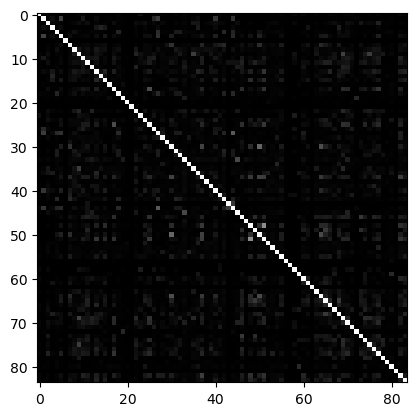

In [17]:
SIM = np.zeros((len(documents_broader),len(documents_broader)),dtype=float)
for curr in range(len(documents_broader)):
    # Itera su ogni documento in analisi
    for i in range(len(documents_broader)):
        # Calcola l'intersezione tra le entità cliniche più ampie dei documenti
        intersez = set(documents_broader[curr]).intersection(set(documents_broader[i]))
        union = set(documents_broader[curr]).union(set(documents_broader[i]))
        # Aggiorna la matrice SIM con la lunghezza dell'intersezione
        # Calcola il coefficiente di Jaccard e aggiorna la matrice SIM
        SIM[curr, i] = len(intersez) / len(union)
import matplotlib.pyplot as plt

plt.imshow(SIM, cmap='gray')
plt.show()

***
***
FACCIO CLUSTERING CON QUESTA MATRICE DI SIMILARITA (SIM)
***
***

HIERARCHICAL AGGLOMERATIVE:

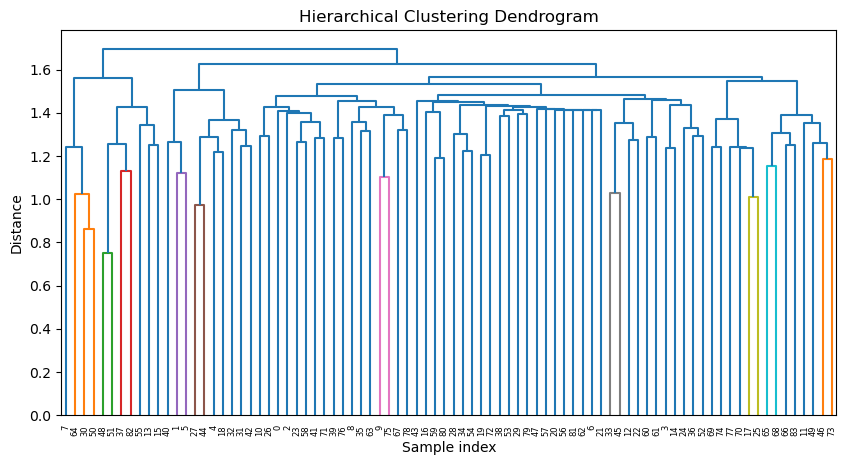

Numero di cluster: 3
Etichette dei cluster: [2 1 2 2 1 1 2 0 2 2 2 2 2 0 2 0 2 2 1 2 2 2 2 2 2 2 2 1 2 2 0 1 1 2 2 2 2
 0 2 2 1 2 1 2 1 2 2 2 0 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2]


In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calcola i collegamenti gerarchici basati sulla matrice di similarità
Z = linkage(SIM, method='complete') # complete linkage mi sembra il migliore

# Plotta il dendrogramma per visualizzare la gerarchia dei cluster
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 1.6  # Altezza di taglio del dendrogramma
clustersHierarchicalUMLS = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicalUMLS))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicalUMLS)

KMEANS:
https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p
kmeans non va bene su matrice di similarità quindi adottiamo k-medoids per tutti i clusters di questo tipo!

In [19]:
import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(SIM)
clustersKMEDOIDSUMLS = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

***
***
FACCIO RANKING BASED METHODS CON LA MATRICE DI SIMILARITA'(SIM)
***
***

In [20]:
# Indici degli elementi di ciascuna riga ordinati in base al valore della similarità
sorted_indices = np.argsort(-SIM, axis=1)  # Ordina in ordine decrescente

# Costruisci la matrice SIMrank
SIMrank = np.zeros_like(SIM, dtype=int)
for i in range(len(SIM)):
    SIMrank[i] = sorted_indices[i]

print(SIMrank)
    

[[ 0 23 10 ... 56 43 49]
 [ 1  5 27 ... 50 30 83]
 [ 2 77 35 ... 62 47 57]
 ...
 [81 53 52 ... 27 34 41]
 [82 37 51 ... 81 58 59]
 [83 68 48 ... 58 72 62]]


In [21]:
import scipy
x=SIMrank[0]
y =SIMrank[23]
scipy.stats.kendalltau(x, y)

KendalltauResult(correlation=-0.06425702811244981, pvalue=0.38685684794551356)

# INFOGRAPH

***
***
EMBEDDINGS
***
***

In [8]:
with open('EmbeddingLayer1and3_InfoGraphTRANSDUCTIVE.pkl', 'rb') as file: #importo gli embedding dei grafi di layer 3
    emb1and3 = pickle.load(file)
emb1and3 = np.delete(emb1and3, 38, axis=0)  # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
emb1and3 = np.delete(emb1and3, 84, axis=0) # e 9056 l'ultimo file ovvero IT102068.xml) (l'86esimo ma ho gia rimosso uno quindi scala)

emb1 = emb1and3[0:84] # seleziono i primi 86 documenti, ovvero quelli relativi a layer 1
#siccome questi due file non contengono clinical entities!
emb3 = emb1and3[84:]

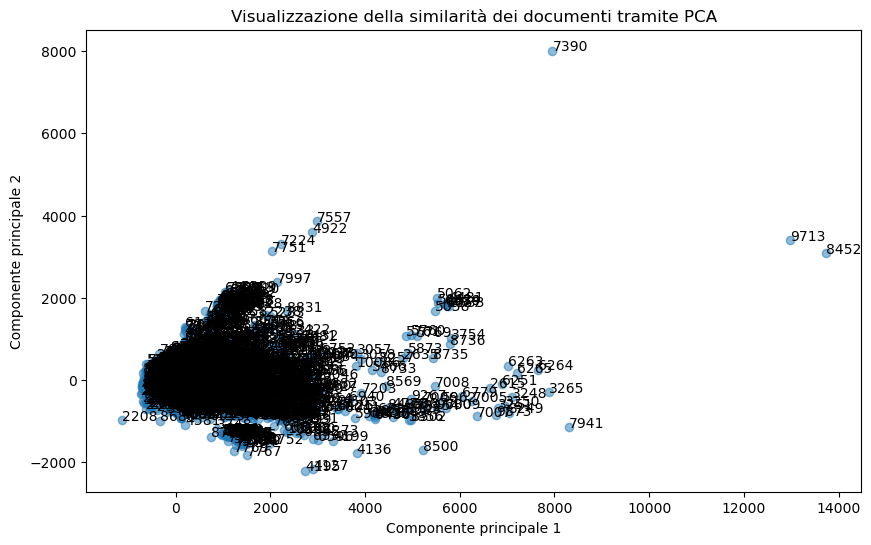

In [3]:
import numpy as np



document_vectors = emb1and3
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2. Applica PCA per ridurre le dimensioni
pca = PCA(n_components=2)  # Vogliamo ridurre a due dimensioni per la visualizzazione
document_embedding = pca.fit_transform(document_vectors)

# 3. Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(document_embedding[:, 0], document_embedding[:, 1], alpha=0.5)
plt.title('Visualizzazione della similarità dei documenti tramite PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')

# Aggiungi etichette per i punti (opzionale)
for i, txt in enumerate(range(len(document_vectors))):
    plt.annotate(txt, (document_embedding[i, 0], document_embedding[i, 1]))

plt.show()



***
***
SIMILARITA (COSINE) E CLUSTERING
***
***

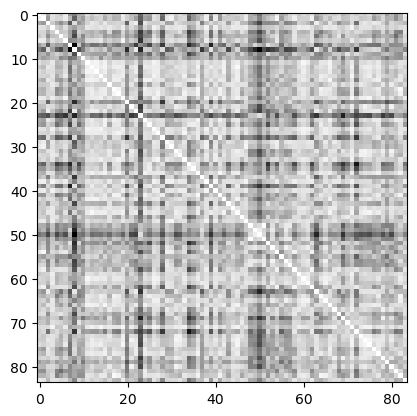

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrix = cosine_similarity(emb1) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix, cmap='gray')
plt.show()

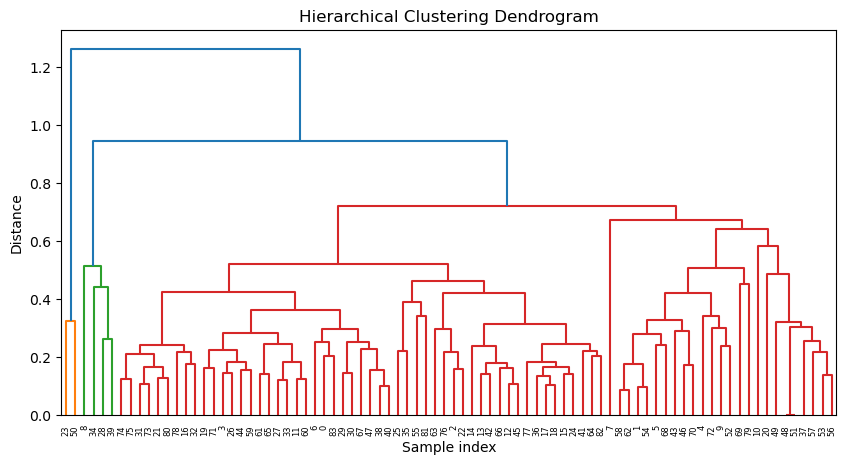

Numero di cluster: 4
Etichette dei cluster: [2 3 2 2 3 3 2 3 1 3 3 2 2 2 2 2 2 2 2 2 3 2 2 0 2 2 2 2 1 2 2 2 2 2 1 2 2
 3 2 1 2 2 2 3 2 2 3 2 3 3 0 3 3 3 3 2 3 3 3 2 2 2 3 2 2 2 2 2 3 3 3 2 3 2
 2 2 2 2 2 3 2 2 2 2]


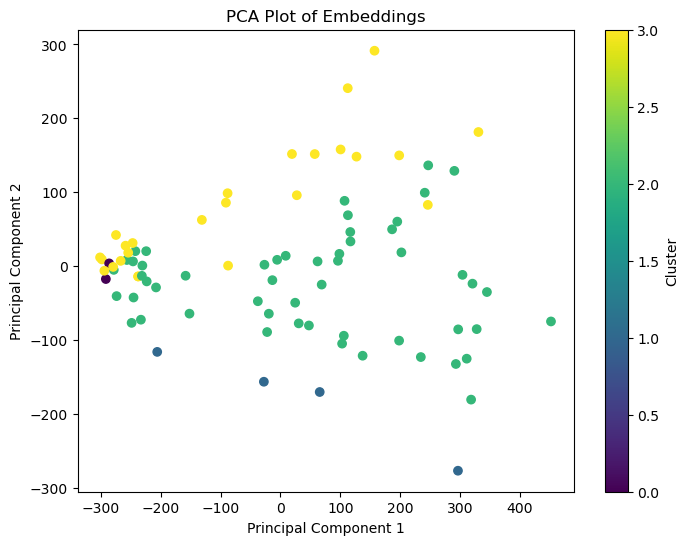

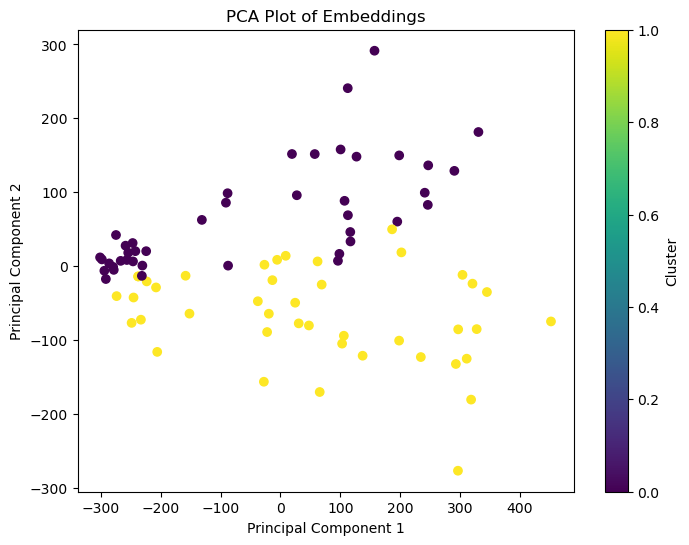

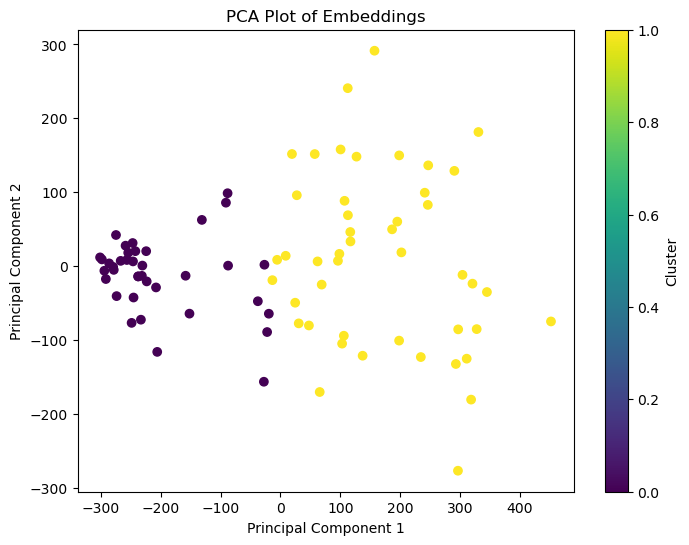

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calcola i collegamenti gerarchici basati sulla matrice di similarità
Z = linkage(similarity_matrix, method='average') # complete linkage mi sembra il migliore

# Plotta il dendrogramma per visualizzare la gerarchia dei cluster
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 0.7  # Altezza di taglio del dendrogramma
clustersHierarchicalInfoGraph = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicalInfoGraph))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicalInfoGraph)

#KMEDOIDS

import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSInfoGraph = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

# infograph embedding:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb1)
clustersKMEANSInfoGraphEMB1 = kmeans.labels_


import numpy as np
from sklearn.decomposition import PCA

# Calcola PCA sui tuoi embedding
pca = PCA(n_components=2)  # Specifica il numero di componenti principali desiderate
embeddings_pca = pca.fit_transform(emb1)  # embeddings è la tua matrice di embedding


#************************************************************************************************
#************************************************************************************************

#NB faccio pca su emb1 ma forse ha piu senso farlo su emb1and3 e poi valutare i risultati sul grafico solo per emb1!

#************************************************************************************************
#************************************************************************************************






# Visualizza solo i primi 84 embedding
embeddings_pca = embeddings_pca[:84]

# Plotta i risultati
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersHierarchicalInfoGraph[:84], cmap='viridis')
plt.title('PCA Plot of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersKMEDOIDSInfoGraph[:84], cmap='viridis')
plt.title('PCA Plot of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Confrontiamo i due cluster precedenti con i cluster ottenuti direttamente dagli embedding (no matrice di similarità ma emb1and3)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersKMEANSInfoGraphEMB1[:84], cmap='viridis')
plt.title('PCA Plot of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()



In [10]:
explained_variance_ratio = pca.explained_variance_ratio_

print("Percentuale di varianza spiegata da ciascuna componente principale:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio*100:.2f}%")

Percentuale di varianza spiegata da ciascuna componente principale:
PC1: 66.78%
PC2: 13.17%


Osserviamo che la seconda componente principale sembra giocare un ruolo chiave nella distinzione dei clusters dati dalla matrice di similarità del coseno! Sembra esserci anche una correlazione fra PC1 e PC2 (strano!!)

Osserviamo anche che clustering con embedding vs clustering con matrice di similarità produce una bella differenza. (vedi l'ultimo grafico sopra vs i penultimi due)

***
***
Rankings UMLS vs ranking INFOGRAPH
***
***

In [29]:
# Indici degli elementi di ciascuna riga ordinati in base al valore della similarità
sorted_indices = np.argsort(-similarity_matrix, axis=1)  # Ordina in ordine decrescente

# Costruisci la matrice SIMrank
similarity_matrixrank = np.zeros_like(similarity_matrix, dtype=int)
for i in range(len(SIM)):
    similarity_matrixrank[i] = sorted_indices[i]

print(similarity_matrixrank)

[[ 0  1 19 ... 34 50 23]
 [ 1 54  0 ... 34 23  8]
 [ 2 22 63 ...  7 23 50]
 ...
 [81 24 17 ... 20 72  5]
 [82 17 64 ...  9  4 72]
 [83  0 19 ... 50 23 34]]


In [22]:
import scipy
media = 0
for i in range(len(SIMrank)):
    kendalltau = scipy.stats.kendalltau(SIMrank[i], similarity_matrixrank[i])
    media+=kendalltau.correlation
    #print(kendalltau)
media = media/len(SIMrank)
print(media,'Correlazione Media UMLS vs Infograph')

import scipy
media = 0
for i in range(len(SIMrank)):
    if i == 0:
        kendalltau = scipy.stats.kendalltau(SIMrank[1], similarity_matrixrank[i])
    else:
        kendalltau = scipy.stats.kendalltau(SIMrank[i-1], similarity_matrixrank[i])
    #print(kendalltau.correlation)
    media+=kendalltau.correlation
media = media/len(SIMrank)

print(media,'Correlazione Media UMLS vs Infograph in maniera casuale')

-9.562057754828967e-05 Correlazione Media UMLS vs Infograph
0.009705488621151271 Correlazione Media UMLS vs Infograph in maniera casuale


Notiamo che la correlazione di UMLS e infoGraph è comparabile alla variabile di controllo dove facciamo confronto a caso. (correlazione in media circa 0, e va da -1 a 1)

***
***
Valutazione documenti (vediamo leggendo i documenti se traspaiono delle somiglianze)
***
***

Creo lista_testi per avere a portata di mano il contenuto dei testi

In [22]:
import os
import json

# Definisci la cartella contenente i file
cartella = r"C:\Users\enduser\OneDrive - Politecnico di Milano\Ingegneria matematica\Tesi\ProveDiCodice\E3C-Corpus\data_collection\Italian\layer1"

# Lista dei testi estratti
lista_testi = []

# Itera su tutti i file nella cartella
for filename in os.listdir(cartella):
    if filename.endswith(".json"):  # Assicurati che siano file JSON
        filepath = os.path.join(cartella, filename)
        with open(filepath, 'r', encoding='utf-8') as file:  # Specifica l'encoding come utf-8
            try:
                # Carica il contenuto del file JSON
                data = json.load(file)
                # Estrai il testo dal campo "text" se presente
                if "text" in data:
                    testo = data["text"]
                    lista_testi.append(testo)
            except Exception as e:
                pass

_ = lista_testi.pop(38) # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
_ = lista_testi.pop(84) #per rimuovere l'86esimo documento di layer 1 devo rimuovere l'85esimo per il pop di prima (quindi84)

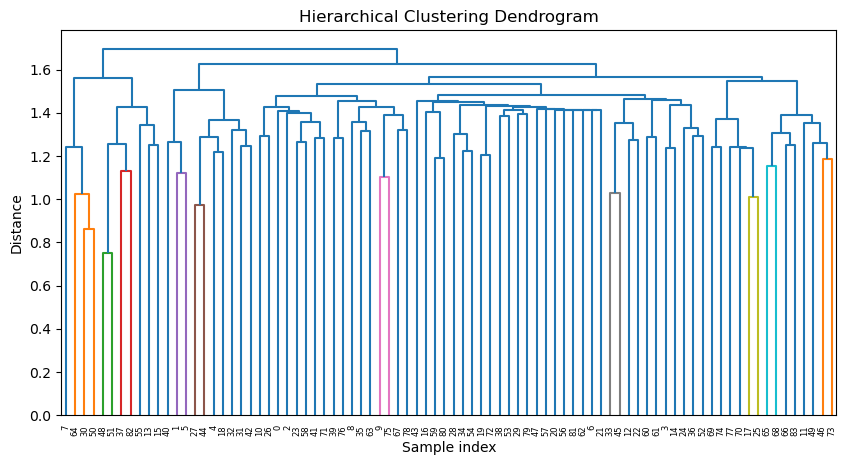

In [23]:
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [24]:
#Vedo se i clusters ottenuti da infoGraph hanno un significato:

# 23 e 50 formano il cluster uno a sinistra, vediamoli

print(lista_testi[23],"\n\n",lista_testi[50])
print(similarity_matrix[23][50])

Caucasico di 68 anni viene sottoposto a coronarografia circa un’ora dopo la comparsa di sintomi di IMA. Viene praticata PTCA primaria. Dopo 6 giorni dalla procedura, comparsa di dolore alle dita dei piedi con cianosi e marezzatura. Progressivo peggioramento del quadro periferico fino alla comparsa di aree di necrosi parcellari alle dita dei piedi. Incremento della creatinina (Cr.:3.2 mg%). Come da consulenza chirurgica, si procede ad amputazione di quattro dita del piede sx e due del piede dx. Al riscontro istologico quadro di embolizzazione da cristalli di colesterolo. Nei due mesi successivi progressivo recupero della funzione renale. 

 Il signor Ugo di anni 63 sposato con due figli, viene ricoverato nell'UO di Medicina per accertamenti. Al ricovero il signor Ugo presenta forti dolori addominali e vomito. Gli viene posizionato un sondino naso gastrico. Dopo vari accertamenti viene diagnosticato un K gastrico con metastasi del fegato e del pancreas. Il signor Ugo viene sottoposto ad 

osservo che questi due testi potrebbero andar messi nella testi siccome sono di layer 1 (quindi hanno le clinical entities e sono corti)!

In [25]:
#secondo cluster formato da 8 34 28 39

print(lista_testi[8],"\n\n",lista_testi[34],"\n\n",lista_testi[28],"\n\n",lista_testi[39])

print(similarity_matrix[8][34])
print(similarity_matrix[8][28])
print(similarity_matrix[8][39])
print(similarity_matrix[28][34])
print(similarity_matrix[39][34])
print(similarity_matrix[28][39])


Una donna di 48 anni viene ricoverata in ambiente ospedaliero nell’agosto del 2011 per la presenza, da circa un mese, di astenia marcata, gonfiore addominale e incremento ponderale. L’anamnesi patologica remota evidenzia un’ipertensione arteriosa scarsamente controllata dalla terapia farmacologica e una storia di ulcera gastrica, in terapia con inibitori di pompa protonica con risoluzione del quadro. Durante il ricovero vengono effettuati esami ematochimici con riscontro di: marcata anemia (Hb = 9,8 g/dl, vn = 12,0-16,0 g/dl); riduzione dell’ematocrito (ematocrito = 31,9%, vn = 37,0-47,0); leucocitosi neutrofila con linfocitopenia (neutrofili = 10,66 × 10³/μl, vn = 1,50-8,00 × 10³/μl; linfociti = 0,52 × 10³/μl, vn = 0,90-4,00 × 10³/μl); lieve rialzo delle transaminasi (GOT = 56 U/l, vn < 32 U/l; GPT = 89 U/l, vn < 31 U/l). All’esame obiettivo non sono presenti alterazioni di rilievo. Per ricercare la causa dell’anemia vengono eseguite una esofagogastroduodenoscopia, che rileva una gast

osservo che questi documenti hanno lunghezza diversa quindi sembra si possa escludere che l'embedding di infograph sia influenzato tanto dalla lunghezza del testo

In [26]:
#osservo che nella seconda metà ci sono 58 62 1 54 che sono molto simili dal dendogram, andiamo a vedere!

print(lista_testi[58],"\n\n,oooooooooooooooooooooooooooooooooooo",lista_testi[62],"\n\n,ooooooooooooooo",
      lista_testi[1],"\n\noooooooooooooooooooooooooooooooooooooooooooooo",lista_testi[54])

print(similarity_matrix[58][62])
print(similarity_matrix[58][1])
print(similarity_matrix[58][54])
print(similarity_matrix[1][62])
print(similarity_matrix[54][62])
print(similarity_matrix[54][1])

Nel luglio del 2002 abbiamo osservato una donna di 60 anni con febbre continua da 6 giorni e 5 escare localizzate a livello degli arti superiori e inferiori accompagnate da linfoadenopatia regionale. Tuttavia le condizioni generali erano buone, sia al momento della prima visita che nei giorni precedenti, e non si è manifestato esantema. La paziente aveva soggiornato in sud Africa per 20 giorni e i primi sintomi sono comparsi 6 giorni dopo il rientro in Patria. I principali esami emato chimici hanno mostrato una modesta ipertransaminasemia e un moderato incremento della VES. La diagnosi sierologica è stata effettuata mediante un test di immuno fluorescenza indiretta per la ricerca delle IgG ed IgM anti Rickettsia (Focus USA, Alifax). Il test utilizza vetrini contenenti antigeni di R. typhy e di R. rickettsii che consentono di discriminare, rispettivamente, il gruppo “Typhus Fever” da quello “Spotted Fever”, quest’ultimo comprendente anche R africae, R. akari, R. conorii, R.
australis, R

In [27]:
SIMrank[0]

array([ 0, 23, 10, 58, 82, 60,  9, 66, 44, 18, 71, 70, 55, 33, 26, 83, 77,
        2, 67, 31, 41, 75,  3, 63, 28, 45, 69, 42, 22, 11, 38, 12, 36, 53,
       61, 79,  5, 52, 13, 29,  4, 35, 54, 14, 39, 32, 65, 68, 24, 76,  8,
       64, 78, 80, 74,  1, 62, 81, 72, 73, 16, 57, 17, 19, 20, 21, 25, 27,
       30, 34, 37, 59, 40,  7, 46, 47, 48, 15, 50, 51,  6, 56, 43, 49])

In [30]:
similarity_matrixrank[0]

array([ 0,  1, 19, 38, 83,  6, 30, 54, 47, 40, 62, 26, 58,  3, 11, 42, 32,
       75, 29, 13, 71, 60, 68,  4, 27, 57, 14, 73, 20, 46, 45, 78, 66, 61,
       33, 65, 72, 74, 67, 44, 16, 12, 31,  5, 59, 70, 43, 77, 53, 21, 15,
       80, 64, 18, 17, 37, 22, 36, 56, 69, 82, 10, 52, 76, 51, 48,  9, 24,
       55, 63,  2, 25, 49, 79,  7, 39, 41, 35, 81,  8, 28, 34, 50, 23])

I risultati alla luce di tutto quanto visto sopra sembrano scoraggianti... sento vittorio.

# Doc2vec

Provo a vedere se doc2vec produce embedding migliori oppure no..., vedi file Doc2Vec_E3C (ho fatto copia incolla da li...), metto qua il codice per poter confrontare i risultati con UMLS e infograph

In [11]:
import pickle
import numpy as np

with open('corpusParoleInutiliStemming.pkl', 'rb') as file:
    # Carica i dati dal file
    corpus_filtrato = pickle.load(file)
#len(corpus_filtrato[0])

with open('corpusParoleInutiliStemming_layer1.pkl', 'rb') as file:
    # Carica i dati dal file
    corpus_filtrato1 = pickle.load(file)
#len(corpus_filtrato[0])

In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Creazione degli oggetti TaggedDocument per il set di addestramento
tagged_training_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_filtrato)]

# Creazione degli oggetti TaggedDocument per il set di test
tagged_test_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_filtrato1)]
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(tagged_training_corpus)

# Addestra il modello
model.train(tagged_training_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [58]:
with open('modeldoc2vec.pkl', 'wb') as file:
    pickle.dump(model, file)

Il codice sopra ci mette circa: 7 minuti

In [13]:
embedding_docs1 = []
for doc in corpus_filtrato1:
    vector = model.infer_vector(doc)
    embedding_docs1.append(vector)
embedding_docs1 = np.delete(embedding_docs1, 38, axis=0)  # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
embedding_docs1 = np.delete(embedding_docs1, 84, axis=0) #(l'86esimo ma ho gia rimosso uno quindi scala)


In [14]:
embedding_docs3 = []
for doc in corpus_filtrato:
    vector = model.infer_vector(doc)
    embedding_docs3.append(vector)

In [59]:
with open('embedding_docs3doc2vec.pkl', 'wb') as file:
    pickle.dump(embedding_docs3, file)

Il codice sopra ci mette circa: 15 min

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


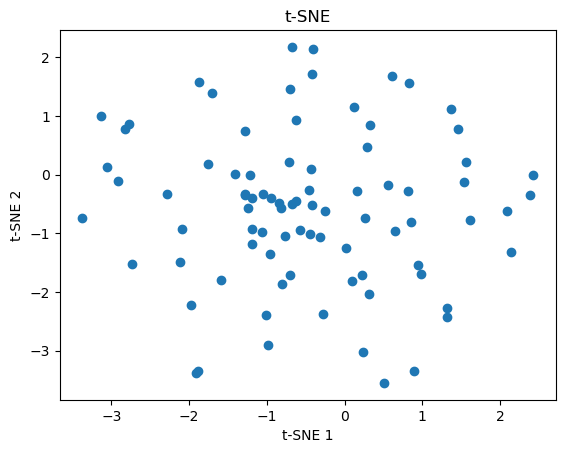

Varianza delle prime 2 componenti principali: [0.11139889 0.08787335]


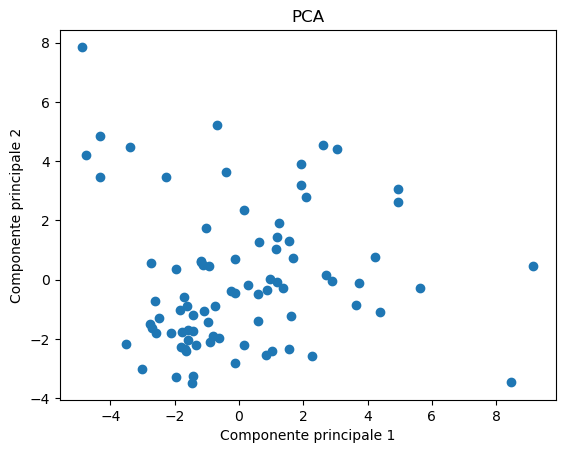

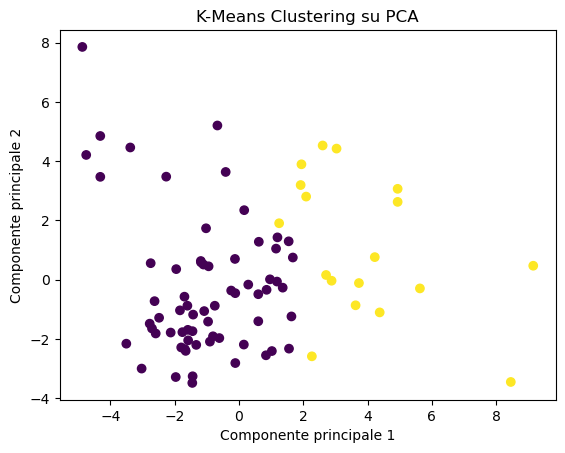

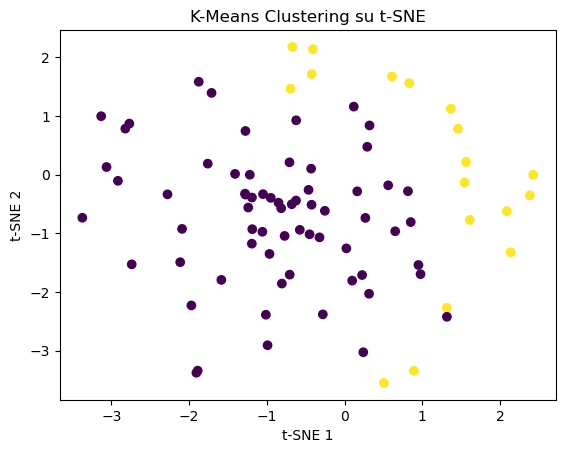

In [31]:
from sklearn.manifold import TSNE

# Esegui t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedding_docs1_tsne = tsne.fit_transform(embedding_docs1)

# Visualizzare i risultati su un piano bidimensionale
plt.scatter(embedding_docs1_tsne[:, 0], embedding_docs1_tsne[:, 1])
plt.title('t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Esegui PCA
pca = PCA(n_components=2)
embedding_docs1_pca = pca.fit_transform(embedding_docs1)

# Stampare la varianza delle prime 2 componenti principali
print("Varianza delle prime 2 componenti principali:", pca.explained_variance_ratio_)

# Visualizzare i risultati su un piano bidimensionale
plt.scatter(embedding_docs1_pca[:, 0], embedding_docs1_pca[:, 1])
plt.title('PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.show()

from sklearn.cluster import KMeans

# Esegui K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embedding_docs1)

# Visualizza i risultati su PCA
plt.scatter(embedding_docs1_pca[:, 0], embedding_docs1_pca[:, 1], c=kmeans.labels_)
plt.title('K-Means Clustering su PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.show()

# Visualizza i risultati su t-SNE
plt.scatter(embedding_docs1_tsne[:, 0], embedding_docs1_tsne[:, 1], c=kmeans.labels_)
plt.title('K-Means Clustering su t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

kmeanemblabels = kmeans.labels_

Osservo che pca non va bene per rappresentare i dati in 2d perchè le prime due pc spiegano meno del 20% della variabilità

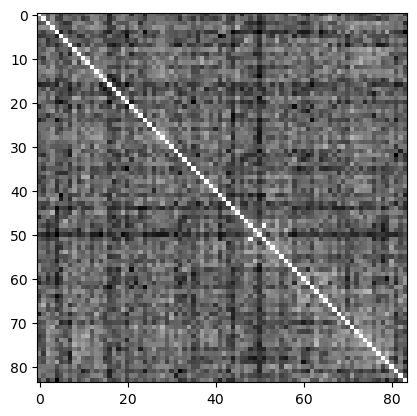

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrixdoc2vec = cosine_similarity(embedding_docs1) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

plt.imshow(similarity_matrixdoc2vec, cmap='gray')
plt.show()

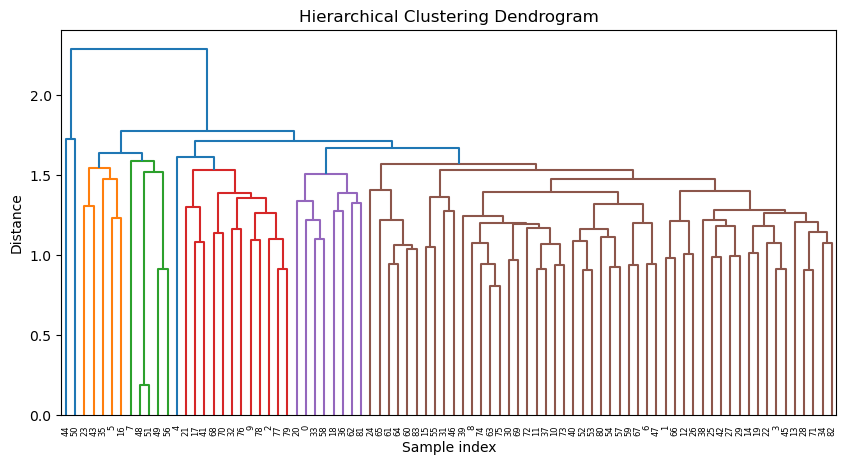

Numero di cluster: 3
Etichette dei cluster: [2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 1 0 2 2 2 1 1 0 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2]


C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


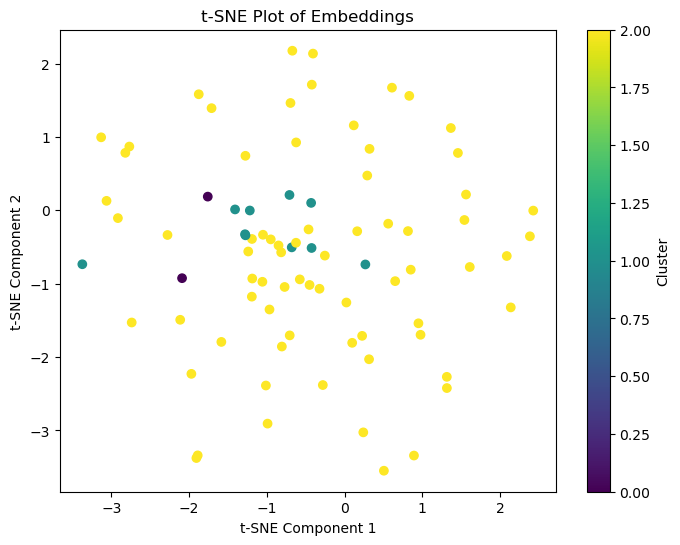

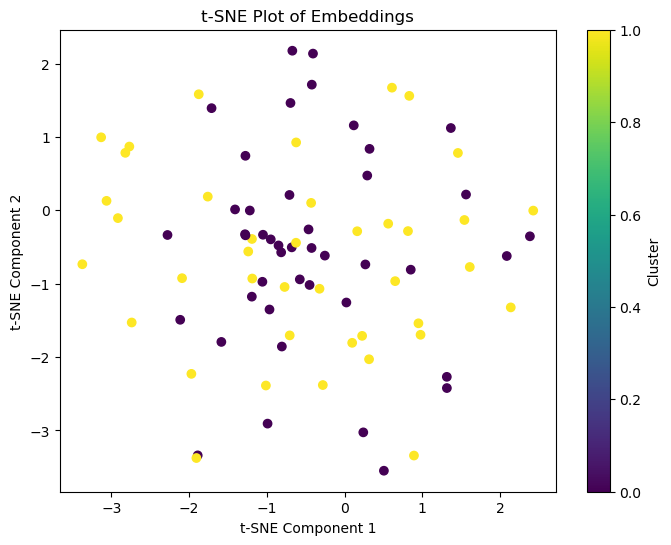

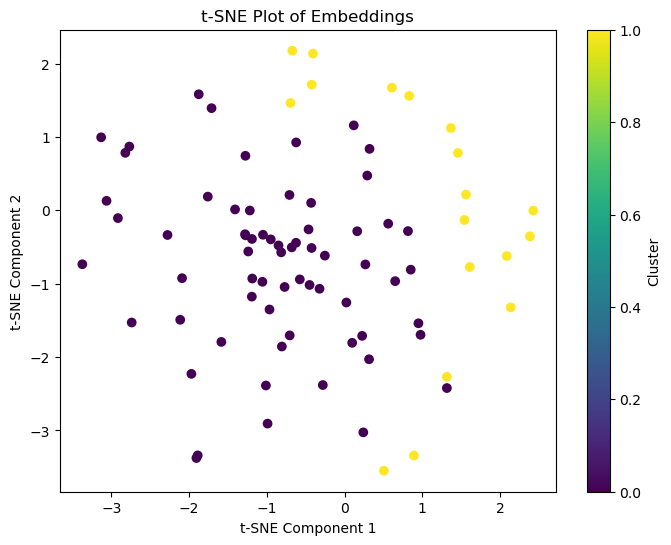

In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calcola i collegamenti gerarchici basati sulla matrice di similarità
Z = linkage(similarity_matrixdoc2vec, method='average') # complete linkage mi sembra il migliore

# Plotta il dendrogramma per visualizzare la gerarchia dei cluster
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 1.75  # Altezza di taglio del dendrogramma
clustersHierarchicaldoc2vec = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicaldoc2vec))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicaldoc2vec)


#KMEDOIDS

import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(similarity_matrixdoc2vec)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]


from sklearn.manifold import TSNE

# Calcola t-SNE sui tuoi embedding
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs1)  # embeddings è la tua matrice di embedding

# Plotta i risultati
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicaldoc2vec[:84], cmap='viridis')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vec[:84], cmap='viridis')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Confrontiamo i due cluster precedenti con i cluster ottenuti direttamente dagli embedding (no matrice di similarità ma emb1and3)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=kmeanemblabels[:84], cmap='viridis')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


osservo che il dendogram non è un granche, kmeans embedding e k medoids sulla base della matrice di similarità producono risultati diversi

***
***
Rankings UMLS vs ranking INFOGRAPH vs doc2vec
***
***

In [35]:
sorted_indices = np.argsort(-similarity_matrixdoc2vec, axis=1)  # Ordina in ordine decrescente

# Costruisci la matrice SIMrank
similarity_matrixdoc2vecrank = np.zeros_like(similarity_matrixdoc2vec, dtype=int)
for i in range(len(similarity_matrixdoc2vec)):
    similarity_matrixdoc2vecrank[i] = sorted_indices[i]

print(similarity_matrixdoc2vecrank)

[[ 0 58 57 ... 24 16 68]
 [ 1 66  3 ... 32 50 16]
 [ 2 77 74 ... 83 60 50]
 ...
 [81 47 62 ... 24 16 32]
 [82 65 71 ... 50 16 31]
 [83 64 60 ... 41 79  4]]


doc2vec rankings vs umls

In [36]:
import scipy
media = 0
for i in range(len(SIMrank)):
    kendalltau = scipy.stats.kendalltau(SIMrank[i], similarity_matrixdoc2vecrank[i])
    media+=np.abs(kendalltau.correlation)
    #print(kendalltau)
media = media/len(SIMrank)
print(media,'Correlazione Media UMLS vs Infograph')

import scipy
media = 0
for i in range(len(SIMrank)):
    if i == 0:
        kendalltau = scipy.stats.kendalltau(SIMrank[1], similarity_matrixdoc2vecrank[i])
    else:
        kendalltau = scipy.stats.kendalltau(SIMrank[i-1], similarity_matrixdoc2vecrank[i])
    #print(kendalltau.correlation)
    media+=np.abs(kendalltau.correlation)
media = media/len(SIMrank)

print(media,'Correlazione Media UMLS vs Infograph in maniera casuale')

0.05285768926044314 Correlazione Media UMLS vs Infograph
0.0551730732453624 Correlazione Media UMLS vs Infograph in maniera casuale


doc2vec rankings vs infograph

In [38]:
import scipy
media = 0
for i in range(len(SIMrank)):
    kendalltau = scipy.stats.kendalltau(similarity_matrixrank[i], similarity_matrixdoc2vecrank[i])
    media+=np.abs(kendalltau.correlation)
    #print(kendalltau)
media = media/len(SIMrank)
print(media,'Correlazione Media UMLS vs Infograph')

import scipy
media = 0
for i in range(len(SIMrank)):
    if i == 0:
        kendalltau = scipy.stats.kendalltau(similarity_matrixrank[1], similarity_matrixdoc2vecrank[i])
    else:
        kendalltau = scipy.stats.kendalltau(similarity_matrixrank[i-1], similarity_matrixdoc2vecrank[i])
    #print(kendalltau.correlation)
    media+=np.abs(kendalltau.correlation)
media = media/len(SIMrank)

print(media,'Correlazione Media UMLS vs Infograph in maniera casuale')

0.059455509111275014 Correlazione Media UMLS vs Infograph
0.0546881403163675 Correlazione Media UMLS vs Infograph in maniera casuale


***
***
Confronto k-medoids clustering (visualizzato su tsne per tutti i possibili metodi)
***
***

Utilizzo sempre il tsne di doc2vec in ogni grafico per avere che tutti i punti siano nelle stesse posizioni!

***

https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p
link utile per usare kmeans quando si ha una matrice di similarità

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


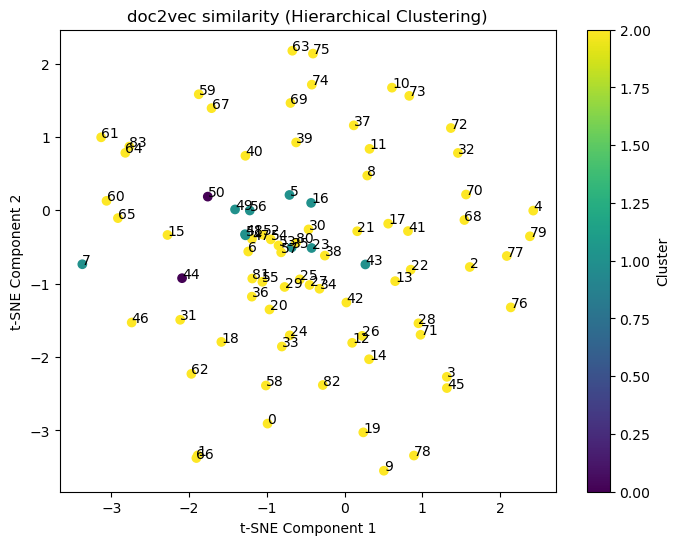

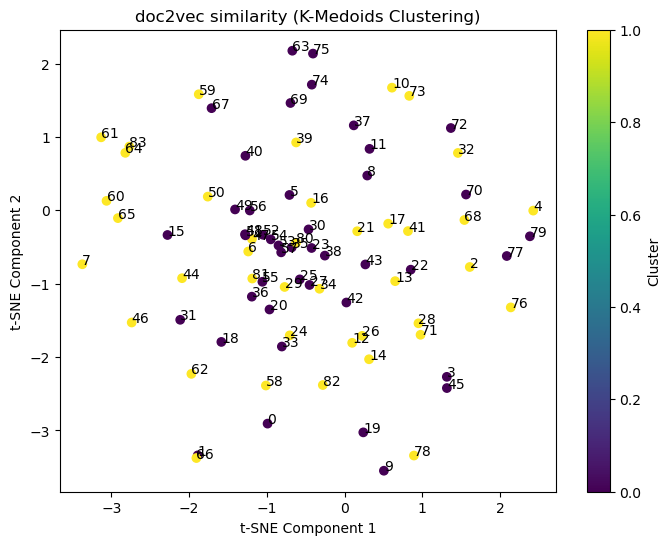

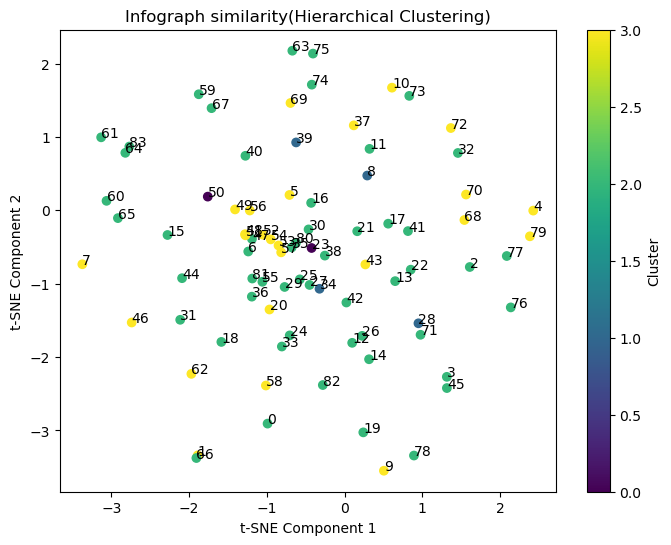

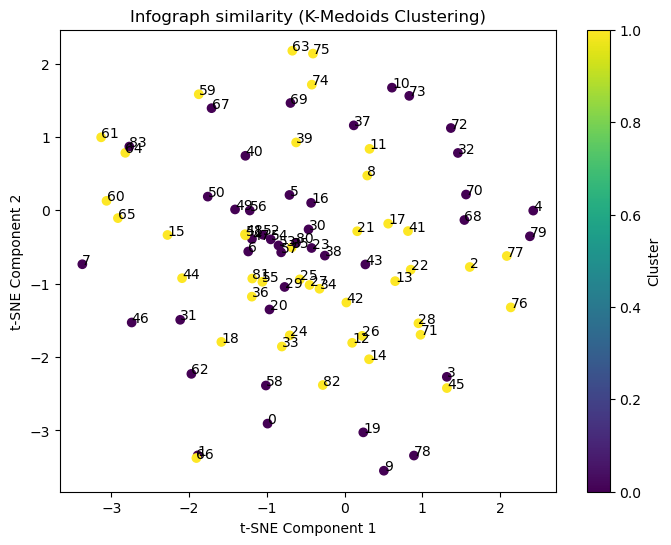

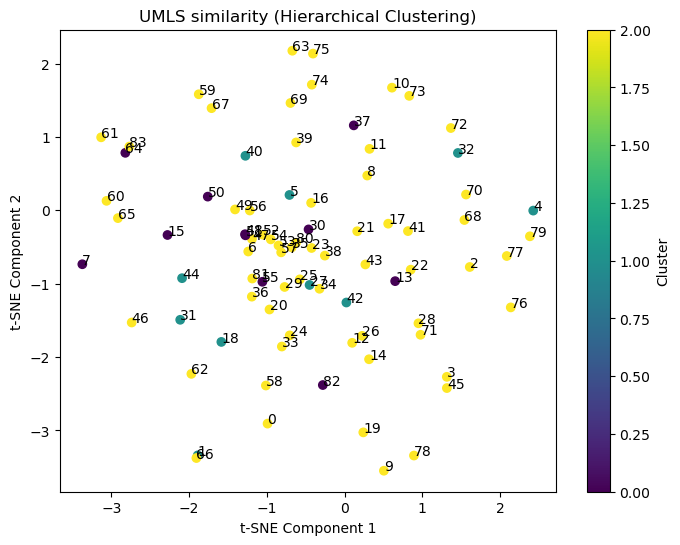

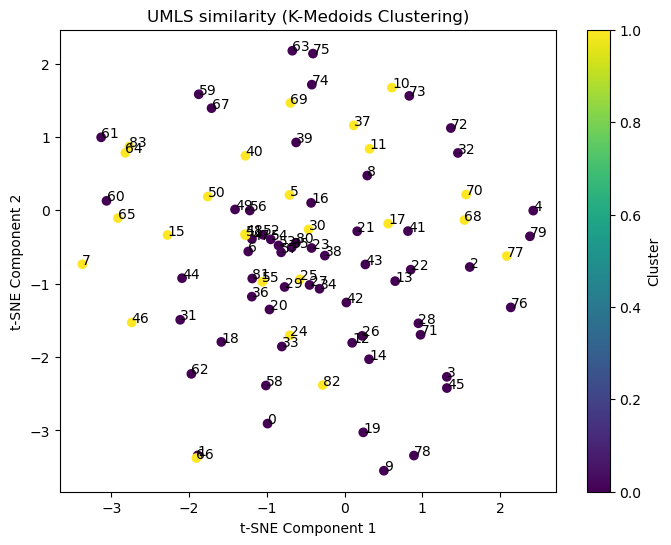

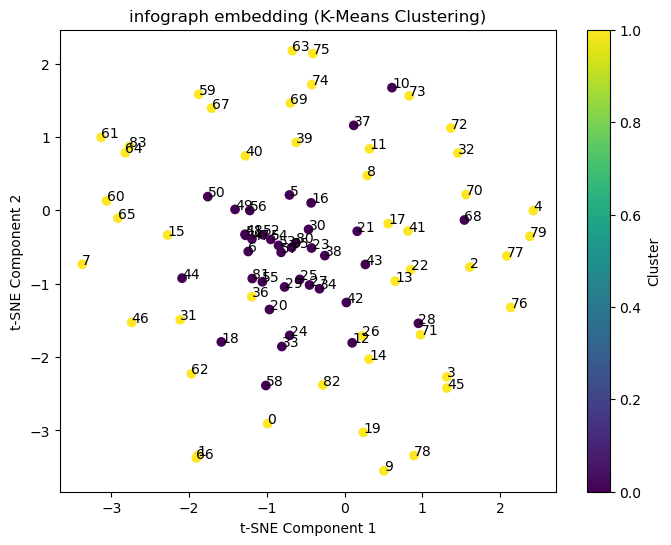

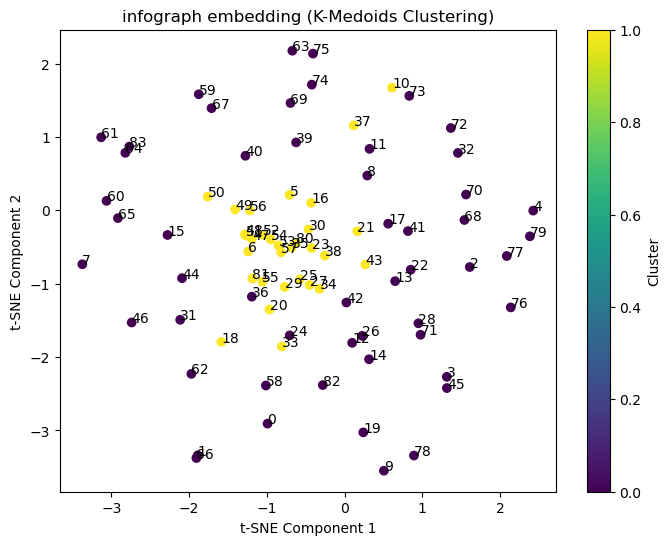

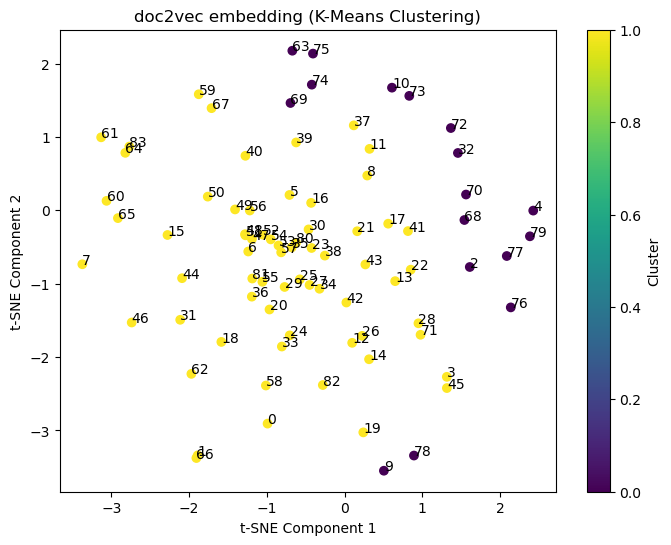

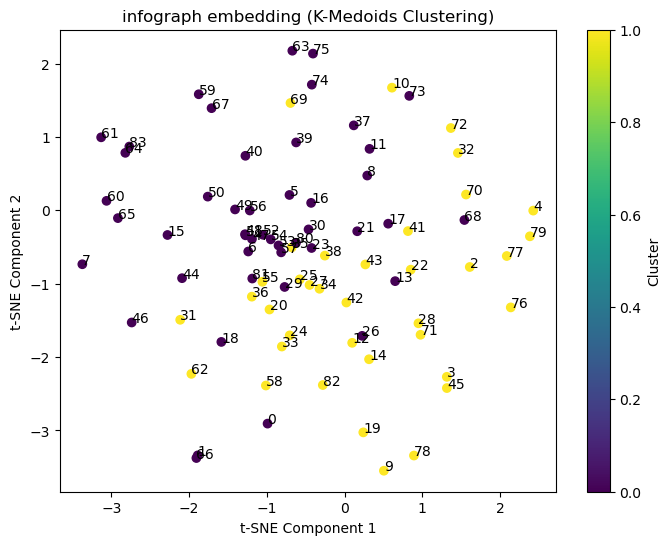

In [45]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs1)  # embeddings è la tua matrice di embedding



# doc2vec similarity:



# Plotta i risultati per Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicaldoc2vec[:84], cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()
# Plotta i risultati per K-Means Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vec[:84], cmap='viridis')
plt.title('doc2vec similarity (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()



# Infograph similarity:



# Plotta i risultati per Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicalInfoGraph[:84], cmap='viridis')
plt.title('Infograph similarity(Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()
# Plotta i risultati per K-Means Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSInfoGraph[:84], cmap='viridis')
plt.title('Infograph similarity (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()




# UMLS similarity:





# Plotta i risultati per Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicalUMLS[:84], cmap='viridis')
plt.title('UMLS similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()
# Plotta i risultati per K-Means Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSUMLS[:84], cmap='viridis')
plt.title('UMLS similarity (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()




# clustering kmeans, k = 3 degli embedding di doc2vec e infograph dagli embedding direttamente (no matrice di similarità)




# infograph embedding:

#kmeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb1)
clustersKMEANSInfoGraphEMB = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSInfoGraphEMB[:84], cmap='viridis')
plt.title('infograph embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()


#kmedoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(emb1)
clustersKMEDOIDSInfoGraphEMB = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSInfoGraphEMB[:84], cmap='viridis')
plt.title('infograph embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()




# doc2vec embedding:

#kmeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embedding_docs1)
clustersKMEANSdoc2vecEMB = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSdoc2vecEMB[:84], cmap='viridis')
plt.title('doc2vec embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()

#kmedoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(embedding_docs1)
clustersKMEDOIDSdoc2vecEMB = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vecEMB[:84], cmap='viridis')
plt.title('infograph embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()



stessa cosa di prima ma ora metto i plot in una tabella:

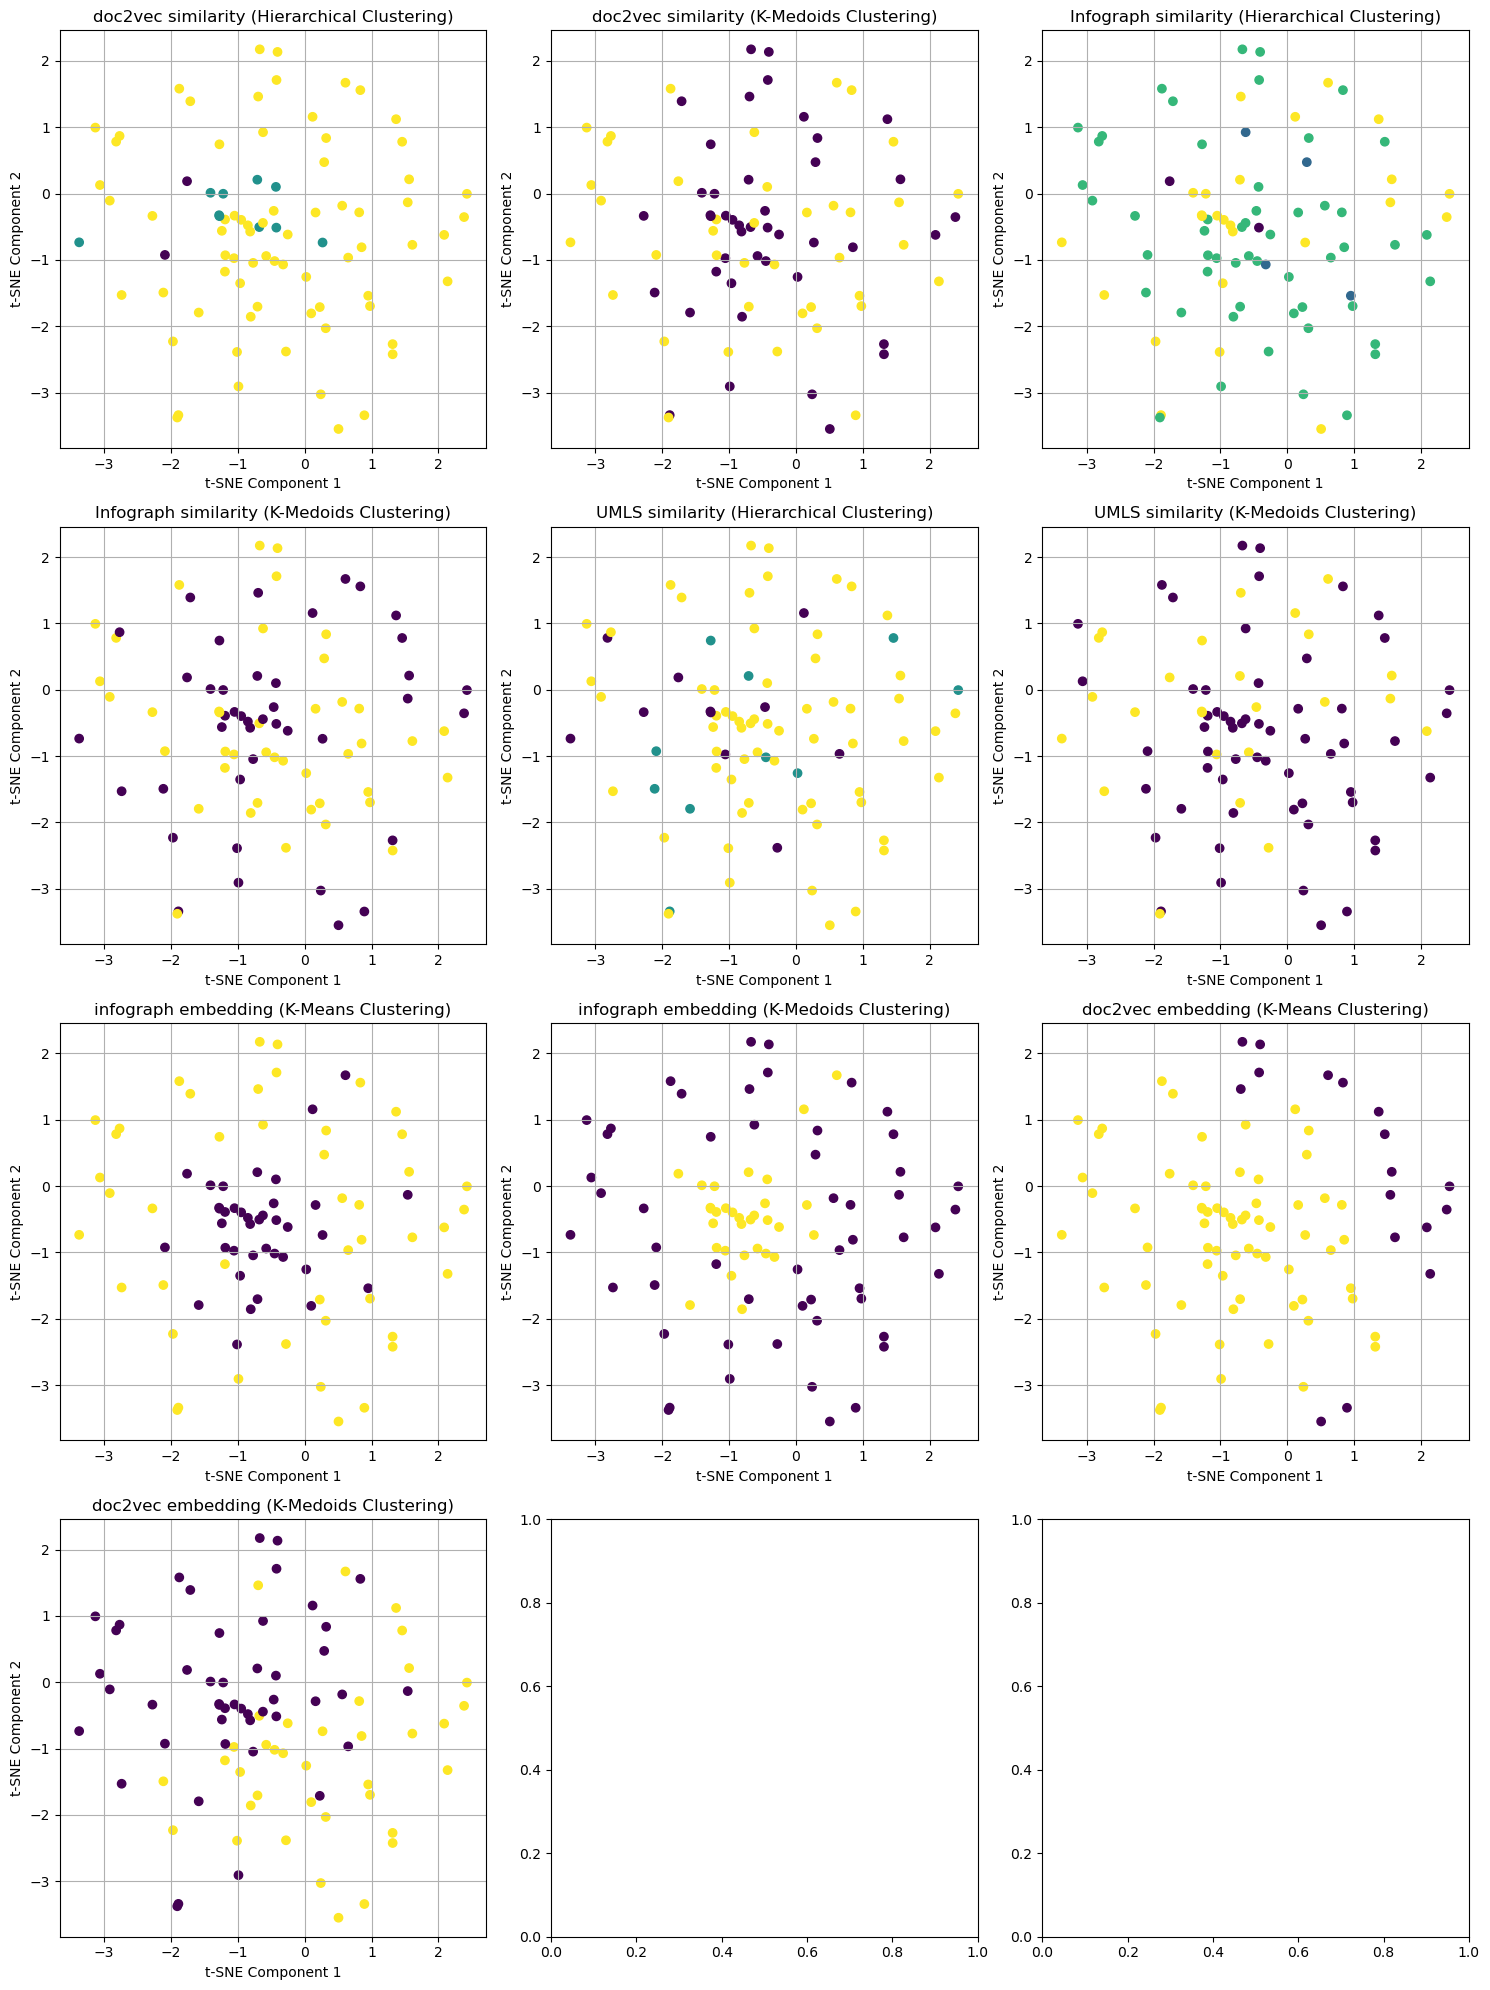

In [47]:
import matplotlib.pyplot as plt

# Impostazione delle dimensioni della figura e della griglia dei subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Lista dei dati e delle etichette dei titoli per ogni grafico
data = [
    (clustersHierarchicaldoc2vec[:84], 'doc2vec similarity (Hierarchical Clustering)'),
    (clustersKMEDOIDSdoc2vec[:84], 'doc2vec similarity (K-Medoids Clustering)'),
    (clustersHierarchicalInfoGraph[:84], 'Infograph similarity (Hierarchical Clustering)'),
    (clustersKMEDOIDSInfoGraph[:84], 'Infograph similarity (K-Medoids Clustering)'),
    (clustersHierarchicalUMLS[:84], 'UMLS similarity (Hierarchical Clustering)'),
    (clustersKMEDOIDSUMLS[:84], 'UMLS similarity (K-Medoids Clustering)'),
    (clustersKMEANSInfoGraphEMB[:84], 'infograph embedding (K-Means Clustering)'),
    (clustersKMEDOIDSInfoGraphEMB[:84], 'infograph embedding (K-Medoids Clustering)'),
    (clustersKMEANSdoc2vecEMB[:84], 'doc2vec embedding (K-Means Clustering)'),
    (clustersKMEDOIDSdoc2vecEMB[:84], 'doc2vec embedding (K-Medoids Clustering)')
]

# Creazione dei grafici per ogni coppia di dati e titoli
for i, (cluster_data, title) in enumerate(data):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_data, cmap='viridis')
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('t-SNE Component 1')
    axes[row, col].set_ylabel('t-SNE Component 2')
    axes[row, col].grid(True)

# Regolazione dello spaziatura tra i subplots
plt.tight_layout()

# Visualizzazione della griglia di subplots
plt.show()

 faccio per tutti i metodi anche KMEDOID al posto di kmeans quando do in input la matrice di similarità perchè questo dovrebbe essere meglio (kmeans non funziona con matrice di similarità! https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p)

Tutti i clusters assieme:


# NB osservo che se uso doc2vec come confronto posso utilizzare anche il layer 3!!: clustering kmeans su layer 3:

In [48]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs3)  # embeddings è la tua matrice di embedding

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


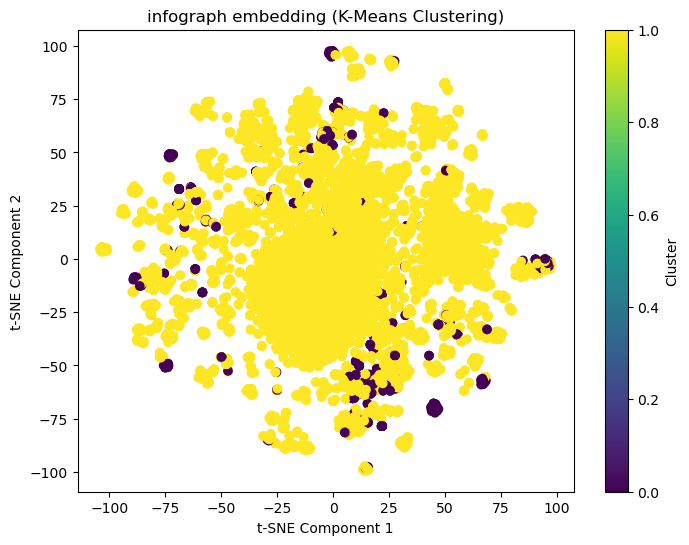

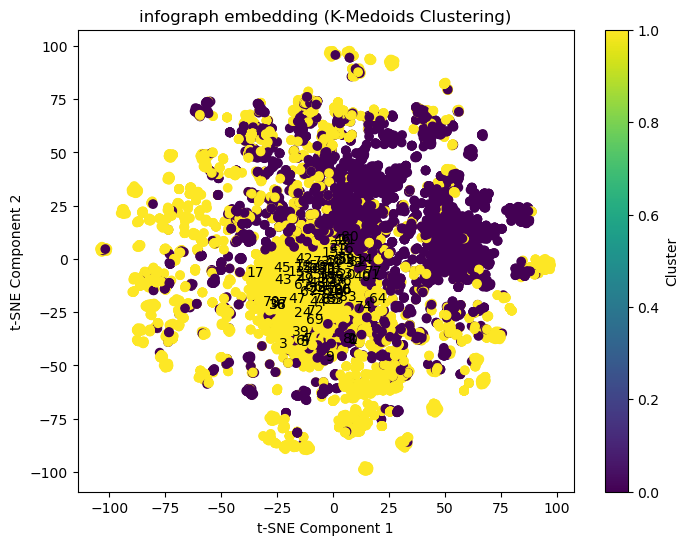

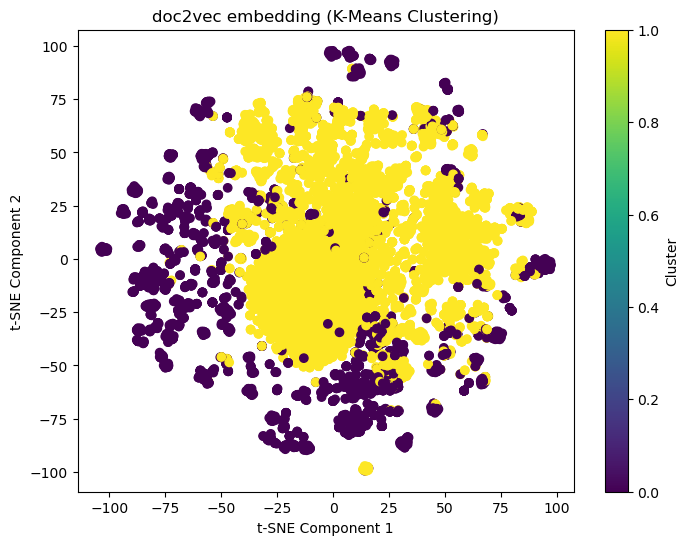

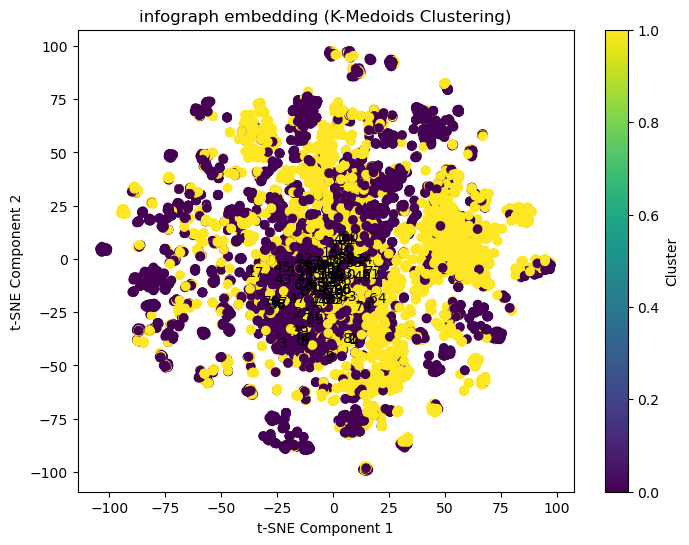

In [51]:
# infograph embedding:
#kmeans


kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb3)
clustersKMEANSInfoGraphEMB3 = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSInfoGraphEMB3, cmap='viridis')
plt.title('infograph embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.show()


#kmedoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(emb3)
clustersKMEDOIDSInfoGraphEMB3 = kmedoids.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSInfoGraphEMB3, cmap='viridis')
plt.title('infograph embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()


# doc2vec embedding:
#kmeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embedding_docs3)
clustersKMEANSdoc2vecEMB3 = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSdoc2vecEMB3, cmap='viridis')
plt.title('doc2vec embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.show()


#kmedoids

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(embedding_docs3)
clustersKMEDOIDSdoc2vecEMB3 = kmedoids.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vecEMB3, cmap='viridis')
plt.title('doc2vec embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()



In [ ]:
print(conta_percentuale_uguali(clustersKMEANSdoc2vecEMB3,clustersKMEANSInfoGraphEMB3)) # non è male il risultato,
# devo pero considerare che le classi sono sbilanciate...:



In [52]:
print(clustersKMEANSdoc2vecEMB3)
count_1 = np.count_nonzero(clustersKMEANSdoc2vecEMB3 == 1)

# Conta quanti 0 ci sono nell'array
count_0 = np.count_nonzero(clustersKMEANSdoc2vecEMB3 == 0)

print("Numero di 1 nella lista:", count_1)
print("Numero di 0 nella lista:", count_0)

count_1 = np.count_nonzero(clustersKMEANSInfoGraphEMB3 == 1)

# Conta quanti 0 ci sono nell'array
count_0 = np.count_nonzero(clustersKMEANSInfoGraphEMB3 == 0)

print("Numero di 1 nella lista:", count_1)
print("Numero di 0 nella lista:", count_0)

[1 1 1 ... 0 0 0]
Numero di 1 nella lista: 6640
Numero di 0 nella lista: 3573
Numero di 1 nella lista: 9585
Numero di 0 nella lista: 628


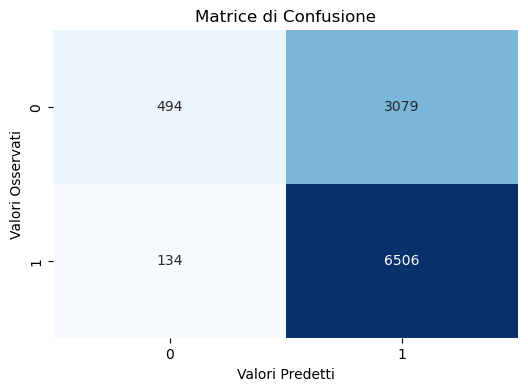

In [53]:
from sklearn.metrics import confusion_matrix

# Esempio di array di valori osservati e array di valori predetti
valori_osservati = clustersKMEANSdoc2vecEMB3
valori_predetti = clustersKMEANSInfoGraphEMB3

# Creazione della matrice di confusione
matrice_confusione = confusion_matrix(valori_osservati, valori_predetti)

import seaborn as sns
# Creazione del plot della matrice di confusione
plt.figure(figsize=(6, 4))
sns.heatmap(matrice_confusione, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valori Predetti')
plt.ylabel('Valori Osservati')
plt.title('Matrice di Confusione')
plt.show()


***
***
# Confronto fra clusters (mapping dei clusters)
***
***

Vediamo quanta corrispondenza c'è fra vari metodi in maniera molto semplice: